In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

import re
import numpy as np

from meltwater_smart_alerts.ml.pipeline import *

import matplotlib as plt
import numpy as np
 
def plot_feature_scores(coef, vocab, index=0):
    markers = ["o", "x"]
    
    figsize(20,8)

    important = np.argsort(np.abs(coef))[-50:]
    important_feature_names = np.array([vocab[idx] for idx in important])
    important_feature_values = coef[important]
    inds = np.argsort(important_feature_values)[::-1]
    important_feature_names = important_feature_names[inds]
    important_feature_values = important_feature_values[inds]
    ylabel("weight")

    ax = plt.gca()
    ax.set_xticks(np.arange(len(important_feature_values)))
    labels = ax.set_xticklabels(important_feature_names)
    plt.setp(labels, rotation=90)
    #plt.plot(important_feature_values, marker="o", c=cm.jet)
    plt.scatter(np.arange(len(important_feature_values)), important_feature_values, c=important_feature_values,marker=markers[index], cmap=cm.autumn)
    print("done")

In [2]:
from os import listdir
from os.path import isfile, join
docLabels = []
docLabels = [f for f in listdir("data/instagram_activities/") if '.csv' in f]

print 'documents:', len(docLabels)
print docLabels

documents: 11
['instagram_activities.csv.0', 'instagram_activities.csv.1', 'instagram_activities.csv.10', 'instagram_activities.csv.2', 'instagram_activities.csv.3', 'instagram_activities.csv.4', 'instagram_activities.csv.5', 'instagram_activities.csv.6', 'instagram_activities.csv.7', 'instagram_activities.csv.8', 'instagram_activities.csv.9']


In [3]:
import pandas as pd

ratings = pd.read_csv('data/instagram_ratings.csv', header=None)
ratings.columns = ['id', 'bool_feedback', 'body', 'feedback', 'rule_id']
ratings.ix[pd.isnull(ratings['feedback']), 'feedback'] = 'good'

print '- - - length:', len(ratings)

- - - length: 3700


In [4]:
import gensim

model = gensim.models.Word2Vec.load('1M_10epochs_hashtags')

model.init_sims(replace=True)

In [5]:
data = ratings[ratings['feedback'].isin(['spam'])]
data = data.append(ratings[ratings['feedback'].isin(['good'])].head(len(data)))

data.loc[:, 'result'] = data.loc[:, 'feedback'].isin(['spam'])
data.loc[:, 'result'] = data.result.astype(int)

print data.groupby(['result']).agg(['count'])

print 'items:', len(data)

data = data.dropna(subset=['body'])
data.drop(['id', 'bool_feedback', 'feedback', 'rule_id'], axis=1, inplace=True)

          id bool_feedback  body feedback rule_id
       count         count count    count   count
result                                           
0        307           307   299      307     307
1        307           307   307      307     307
items: 614


In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

from time import time, ctime

pipeline = Pipeline([
  ('body_lowercase', TextToLowerCase(cols=['body'])),
  ("debugger1", PipelineDebugger('body')),
  ('number_mentions', NumberOfMentions(cols=['body'])),
  ('number_hashtags', NumberOfHashtags(cols=['body'])),
  ('number_periods', NumberOfPeriods(cols=['body'])),
  ('number_urls', NumberOfURLs(cols=['body'])),
  ("debugger2", PipelineDebugger('entities')),
  ('number_words', NumberOfWords(cols=['body'])),
  ('number_camel_words', NumberCamelCaseWords(cols=['body'])),
  ('number_words_per_period', AvgWordsPerPeriod(cols=['body'])),        
  ("debugger3", PipelineDebugger('words')),
  ('number_uppercase_chars', NumberUpperCaseChars(cols=['body'])),
  ('number_punctuation_chars', NumberNonAlphaNumChars(cols=['body'])),
  ("debugger4", PipelineDebugger('chars')),
  ('semantic_distance', HashtagDistanceTransformer(model, ['body'])),
  ("debugger5", PipelineDebugger('distance')),
  ("body_tfidf", DataFrameTfidfVectorizer(col=['body'], 
                          prefix="body",
                          should_treat_special_chars=False,
                          ngram_range=(1, 3), 
                          analyzer="word",
                          binary=True, #False
#                           min_df = 2,
                          max_features = 50)),
  ("debugger6", PipelineDebugger('tdidf')),
  ("drop_text_cols", DropColumnsTransformer(['body'])),
  ("nparray", NumpyArrayTransformer()),
  ('tree', DecisionTreeClassifier(max_depth = 5, min_samples_split = 2))
])

parameters = {
#     'body_tfidf__min_df': (2, 5, 10),
#     'body_tfidf__max_features': (50, 500, 1000),
#     'tree__max_depth': (5, 10),  # unigrams or bigrams
#     'tree__min_samples_split': (2, 5)
}

k_fold = KFold(n=len(data), n_folds=2, shuffle=True)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=3, cv=k_fold)

grid_train = data.loc[:, ['body']].copy()
grid_result = data.loc[:, 'result'].values

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:", parameters)
t0 = time()
grid_search.fit(grid_train, grid_result)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
('pipeline:', ['body_lowercase', 'debugger1', 'number_mentions', 'number_hashtags', 'number_periods', 'number_urls', 'debugger2', 'number_words', 'number_camel_words', 'number_words_per_period', 'debugger3', 'number_uppercase_chars', 'number_punctuation_chars', 'debugger4', 'semantic_distance', 'debugger5', 'body_tfidf', 'debugger6', 'drop_text_cols', 'nparray', 'tree'])
('parameters:', {})
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................
body

/Library/Python/2.7/site-packages/pandas/core/indexing.py:482: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Library/Python/2.7/site-packages/pandas/core/indexing.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


 - Fri Apr 22 19:18:34 2016 (303, 1)
entities - Fri Apr 22 19:18:43 2016 (303, 4)
words - Fri Apr 22 19:18:50 2016 (303, 7)
chars - Fri Apr 22 19:18:55 2016 (303, 9)
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')
distance - Fri Apr 22 19:18:55 2016 (303, 12)
tdidf - Fri Apr 22 19:18:55 2016 (303, 13)
body - Fri Apr 22 19:18:56 2016 (303, 1)
entities - Fri Apr 22 19:19:04 2016 (303, 4)
words - Fri Apr 22 19:19:11 2016 (303, 7)
chars - Fri Apr 22 19:19:16 2016 (303, 9)
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'a

/Library/Python/2.7/site-packages/pandas/core/indexing.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min



distance - Fri Apr 22 19:19:16 2016 (303, 12)
tdidf - Fri Apr 22 19:19:16 2016 (303, 13)
[CV] ....................................... , score=0.650165 -  43.7s
[CV]  ................................................................
body - Fri Apr 22 19:19:43 2016 (303, 1)
entities - Fri Apr 22 19:19:51 2016 (303, 4)
words - Fri Apr 22 19:19:59 2016 (303, 7)
chars - Fri Apr 22 19:20:04 2016 (303, 9)
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')
distance - Fri Apr 22 19:20:04 2016 (303, 12)
tdidf - Fri Apr 22 19:20:04 2016 (303, 13)
body - Fri Apr 22 19:20:06 2016 (303, 1)
entities - Fri Apr 22 19:20:14 2016 (303, 4)
words - Fri Apr 22 19:20:21 2016 (30

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min finished


Populating the interactive namespace from numpy and matplotlib
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')
done


`%matplotlib` prevents importing * from pylab and numpy


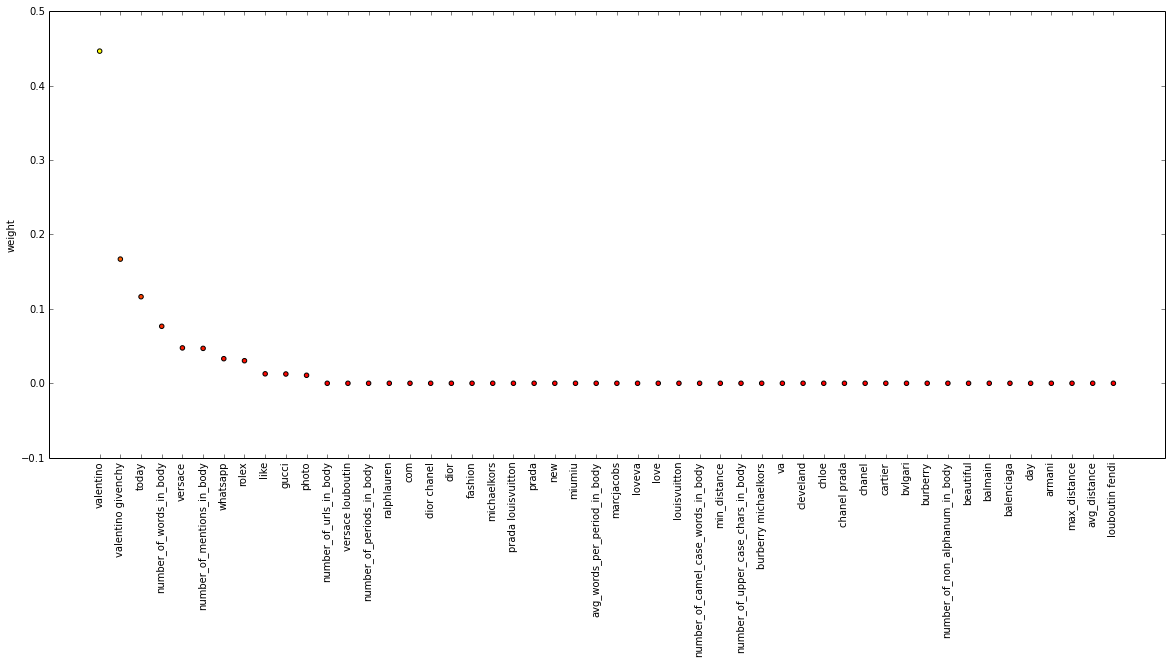

In [8]:
%pylab inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

from time import time, ctime

grid_train = data.loc[:, ['body']].copy()
grid_result = data.loc[:, 'result'].values

best_pipeline = Pipeline([
  ('body_lowercase', TextToLowerCase(cols=['body'])),

  ('number_mentions', NumberOfMentions(cols=['body'])),
  ('number_hashtags', NumberOfHashtags(cols=['body'])),
  ('number_periods', NumberOfPeriods(cols=['body'])),
  ('number_urls', NumberOfURLs(cols=['body'])),

  ('number_words', NumberOfWords(cols=['body'])),
  ('number_camel_words', NumberCamelCaseWords(cols=['body'])),
  ('number_words_per_period', AvgWordsPerPeriod(cols=['body'])),        

  ('number_uppercase_chars', NumberUpperCaseChars(cols=['body'])),
  ('number_punctuation_chars', NumberNonAlphaNumChars(cols=['body'])),

  ('semantic_distance', HashtagDistanceTransformer(model, ['body'])),
    
  ("body_tfidf", DataFrameTfidfVectorizer(col='body', 
                          prefix="body",
                          should_treat_special_chars=False,
                          ngram_range=(1, 3), 
                          analyzer="word",
                          stop_words='english',
                          binary=True, #False
                          max_features = 50)),
  ("drop_text_cols", DropColumnsTransformer(['body'])),
  ("nparray", NumpyArrayTransformer()),
  ('tree', DecisionTreeClassifier(max_depth = 5, min_samples_split = 2))
])

best_pipeline.fit(grid_train, grid_result)

features = [   u'number_of_mentions_in_body',
                u'number_of_periods_in_body',
                  u'number_of_words_in_body',
                   u'number_of_urls_in_body',
       u'number_of_camel_case_words_in_body',
             u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
           u'number_of_non_alphanum_in_body',
                             u'avg_distance',
                             u'max_distance',
                             u'min_distance']

plot_feature_scores(best_pipeline.named_steps['tree'].feature_importances_, features + best_pipeline.named_steps['body_tfidf'].get_feature_names(), 0)

In [9]:
from sklearn.externals import joblib

model_path = "data/instagram_spam_model_20160405.pkl"
joblib.dump(best_pipeline, model_path, compress=9)

['data/instagram_spam_model_20160405.pkl',
 'data/instagram_spam_model_20160405.pkl_01.npy.z',
 'data/instagram_spam_model_20160405.pkl_02.npy.z',
 'data/instagram_spam_model_20160405.pkl_03.npy.z']

In [10]:
best_pipeline.predict(pd.DataFrame([{'body': 'This is a test'}]))

Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')


array([0])

In [11]:
trained = data.loc[:, ['body']].copy()
trained_result = data.loc[:, 'result'].values

trained.loc[:, 'predicted_result'] = best_pipeline.predict(trained)
trained.loc[:, 'result'] = data.loc[:, 'result'].values

Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')


In [12]:
#misclassifications = trained[trained['result'] != trained['predicted_result']]

print trained.groupby(['result', 'predicted_result'])['result', 'predicted_result'].agg(['count'])

                        result predicted_result
                         count            count
result predicted_result                        
0      0                   267              267
       1                    32               32
1      0                    81               81
       1                   226              226
